<a href="https://colab.research.google.com/github/kavyajeetbora/civil_engineering/blob/master/waste_classification%20and%20segregation/waste_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy

#plt.ion() # for interactive mode

## 1. Load the data

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
image_folder = '/gdrive/My Drive/Colab Notebooks/Projects/Side Projects/Waste Segregation/image_dataset'
image_datasets = {}
image_dataloader = {}

data_transforms = {'train': transforms.Compose([
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
  ]), 'val': transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.224])
  ])
}

for data_type in ['train','val']:
  image_datasets[data_type] = datasets.ImageFolder(os.path.join(image_folder,data_type), transform=data_transforms[data_type])
  image_dataloader[data_type] = torch.utils.data.DataLoader(image_datasets[data_type], shuffle=True, batch_size=4, num_workers=4)
 
classes = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
print(device)
print('classes:',classes)

cuda:0
classes: ['Food', 'Metal', 'Plastic']


torch.Size([4, 3, 224, 224])


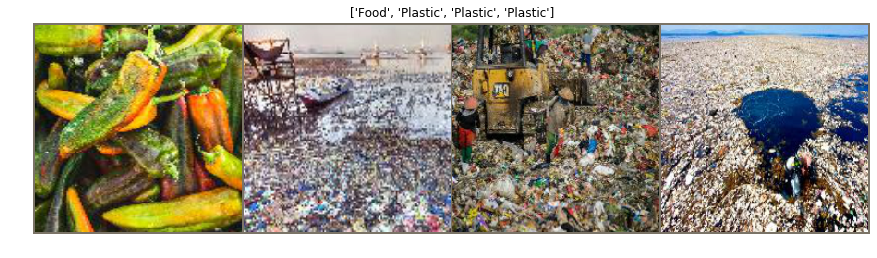

In [4]:
## displaying the images

images, labels = next(iter(image_dataloader['train']))
print(images.size())

def display_image(img, label=None):
  img = img.numpy()
  img = np.transpose(img, (1,2,0))
  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229,0.224,0.224])
  img = img*std+mean
  img = np.clip(img,0,1)
  plt.figure(figsize=(15,10))
  plt.imshow(img)
  plt.axis('off')
  if label is not None:
    plt.title(label)
  
  
display_image(torchvision.utils.make_grid(images), [classes[x] for x in labels])

## 2. Defining the model

In [5]:
model = models.resnet18(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 26582041.21it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [6]:
# modifying the last layer to 2 features

model.fc = nn.Linear(model.fc.in_features,3)
print(model.fc)

Linear(in_features=512, out_features=3, bias=True)


In [0]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## 3. Training the model

- Scheduling the learning rate
- Saving the best model

In [8]:
def train_model(model, optimizer, criterion, scheduler, num_epochs=25):
  since = time.time()
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch,num_epochs-1))
    print('-'*10)

    for phase in ['train','val']:

      if phase is 'train':
        scheduler.step()
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_correct = 0.0
      for images,labels in image_dataloader[phase]:
        
        # feeding the images of batch size = 4

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outputs = model(images)
          preds = torch.argmax(outputs,dim=1)
          loss = criterion(outputs,labels)
          
          if phase is 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss
        running_correct += torch.sum(preds==labels.data)


      epoch_loss = running_loss/len(image_datasets[phase])
      epoch_acc =  running_correct.double()/len(image_datasets[phase])

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase,epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc > best_acc:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = epoch_acc
      
    print()
  time_elapsed = time.time() - since
  print('Training complete in: {:.0f}m {:.0f}s'.format(time_elapsed/60, time_elapsed%60))
  print('Best accuracy: {:.2f}'.format(best_acc))
  
  model.load_state_dict(best_model_wts)
  return model

trained_model = train_model(model, optimizer, criterion, exp_lr_scheduler)

Epoch 0/24
----------
train Loss: 0.1815 Acc: 0.6560
val Loss: 0.1211 Acc: 0.8036

Epoch 1/24
----------
train Loss: 0.1646 Acc: 0.7523
val Loss: 0.0642 Acc: 0.8750

Epoch 2/24
----------
train Loss: 0.1078 Acc: 0.8303
val Loss: 0.0583 Acc: 0.8393

Epoch 3/24
----------
train Loss: 0.1554 Acc: 0.7661
val Loss: 0.0983 Acc: 0.8571

Epoch 4/24
----------
train Loss: 0.1753 Acc: 0.7523
val Loss: 0.1370 Acc: 0.7679

Epoch 5/24
----------
train Loss: 0.1441 Acc: 0.7982
val Loss: 0.1013 Acc: 0.7857

Epoch 6/24
----------
train Loss: 0.1318 Acc: 0.7936
val Loss: 0.0387 Acc: 0.9643

Epoch 7/24
----------
train Loss: 0.1200 Acc: 0.8303
val Loss: 0.0281 Acc: 0.9821

Epoch 8/24
----------
train Loss: 0.0956 Acc: 0.8486
val Loss: 0.0392 Acc: 0.9286

Epoch 9/24
----------
train Loss: 0.0920 Acc: 0.8716
val Loss: 0.0302 Acc: 0.9643

Epoch 10/24
----------
train Loss: 0.0800 Acc: 0.8761
val Loss: 0.0276 Acc: 0.9643

Epoch 11/24
----------
train Loss: 0.0908 Acc: 0.8761
val Loss: 0.0336 Acc: 0.9643

Ep

['Metal', 'Plastic', 'Food', 'Metal']


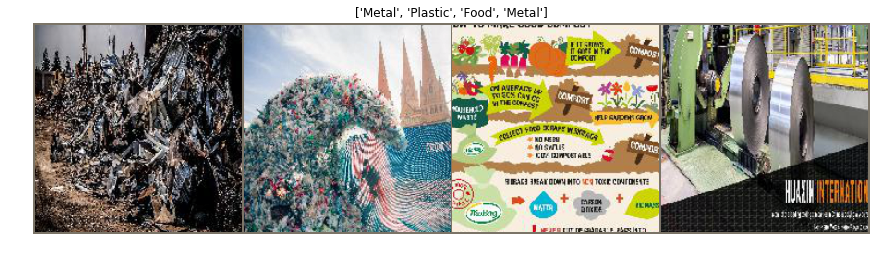

In [12]:
# visualizing the model
def visualize_prediction(model):
  images, labels = next(iter(image_dataloader['val']))
  preds = torch.argmax(model(images.to(device)),dim=1)
  display_image(torchvision.utils.make_grid(images), [classes[x.item()] for x in preds])
  print([classes[x] for x in preds])
visualize_prediction(trained_model)

## 4. ConvNet as fixed feature extractor

In [0]:
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False
  
# Parameters of newly constructed modules have requires_grad=True by default
model_conv.fc = nn.Linear(model_conv.fc.in_features,3)
model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [14]:
trained_conv_net = train_model(model_conv, optimizer_conv, criterion, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2659 Acc: 0.4862
val Loss: 0.1394 Acc: 0.8036

Epoch 1/24
----------
train Loss: 0.1698 Acc: 0.6972
val Loss: 0.0728 Acc: 0.9107

Epoch 2/24
----------
train Loss: 0.1417 Acc: 0.7982
val Loss: 0.0519 Acc: 0.9464

Epoch 3/24
----------
train Loss: 0.1334 Acc: 0.7982
val Loss: 0.0677 Acc: 0.8571

Epoch 4/24
----------
train Loss: 0.1158 Acc: 0.8073
val Loss: 0.0388 Acc: 0.9643

Epoch 5/24
----------
train Loss: 0.0989 Acc: 0.8486
val Loss: 0.0227 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.1070 Acc: 0.8303
val Loss: 0.0333 Acc: 0.9821

Epoch 7/24
----------
train Loss: 0.1141 Acc: 0.8119
val Loss: 0.0265 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.0849 Acc: 0.8578
val Loss: 0.0242 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.0980 Acc: 0.8211
val Loss: 0.0286 Acc: 0.9821

Epoch 10/24
----------
train Loss: 0.1022 Acc: 0.8670
val Loss: 0.0281 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.1079 Acc: 0.8578
val Loss: 0.0292 Acc: 1.0000

Ep

['Food', 'Food', 'Plastic', 'Metal']


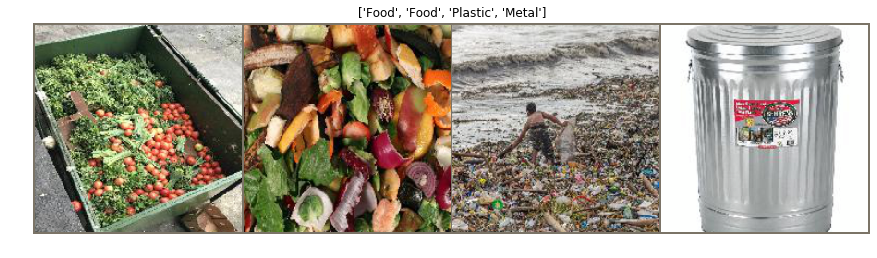

In [15]:
visualize_prediction(trained_conv_net)